# Two hyperplanes trading bot

## Model
$x(t) \in \mathbb{R}^n$ represent the n-dimension curve, which means the feature of market at time $t$.

There are two planes  ${w}^T(x-p)=0$ and ${u}^T(x-q)=0$ called trading planes, which partition $\mathbb{R}^n$ into 4 regions.
$${w}^T(x-p)>=0 \; and \; {u}^T(x-q)>=0 : Buy\;region $$
$${w}^T(x-p)>=0 \; and \; {u}^T(x-q)<0 : Hold\;region $$
$${w}^T(x-p)<0 \; and \; {u}^T(x-q)<0 : Sell\;region $$
$${w}^T(x-p)<0 \; and \; {u}^T(x-q)>=0 : Hold\;region $$

## Estimate
To determine the two hyperplanes, we need to uniquely determine the unit normal vector ${w}$, ${u}$ and shift ${p}$, ${q}$.  The philosophy of the strategy is $x(t)$ oscillate in feature space like the market.  The center point should be choose as the average of the feature space, denoted by ${p}^*$

So the two hyperplanes are modelde as ${w}^T(x-{p}^*)$ and ${u}^T(x-{p}^*)$.  The next step is to determine the two unit vector ${w}$ and ${u}$.  Let's use [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES)

## Action and Objective
The definition of objective function can be set as $$\frac{r - \bar{r}}{\lambda(\sigma + \bar{\sigma})}$$
$r$ represent the annualized return, ${\sigma}$ is the annualized **downward** volatility, $\lambda$ is the panelty of the downward volatility.  For a given period $[0, T]$, there are serveral simple mode to help calculate the loss function:
- Spot mode:
  - Initial fund is 50%, 50% of the asset of token, USDT.
  - Once $x(t)$ first enter buy space, use all USDT to buy token.  Otherwise, sell all token to USDT
- Perp mode (1):
  - Initial position is 0
  - Once $x(t)$ first enter buy space, enter long position with position 1, Hold until $x(t)$ enter sell space and reverse the position
- Perp model (2):
  - Initial position is 0
  - Once $x(t)$ is in buy space, the position is 1.  Else if $x(t)$ is in hold space, position is 0, else $x(t)$ is in sell space, the position is -1.


## MLOps
To identify the effectiveness, there should be a series of MLOps for time-series, let's skip this part and address in next notebook.

## Risk management
Skip first and will address in the future notebook

## Backtest and Production
After finding the two hyperplanes, we can determine the actual strategy by study the geometry to elaborate the parameters like quantity, or the strength of the signal to determine whether we can buy or skip the buy.  Some geometry are list below:
$$\frac{d}{dt} x(t) \;tangent\;of\;x(t)$$
$$\left\| \frac{d}{dt} x(t) \right\| \;speed\;of\;x(t)$$
$$\int_{a}^{b} \left\| \frac{d\mathbf{x}}{dt} \right\| \, dt\;arc length\;of\;x(t)$$
and other geometry like period of a buy-sell cycle, projection from $x(t)$ to buy/sell planes, etc

## Report
A report should contains some MLOps statistics, but we can still deliver some financial index like: return, volatility, MDD and sharpe ratio for reference.
In spot, we can benchmark the portfolio with holding BTC, holding ETH.



# Finding Hyperplanes


In [1]:
# Run it when crypto-backtest is updated, and then restart the kernel
!pip uninstall crypto-backtest -y
!pip install git+https://github.com/BullionBear/crypto-backtest.git

  Cloning https://github.com/BullionBear/crypto-backtest.git to /tmp/pip-req-build-g0y4qckn
  Running command git clone --filter=blob:none --quiet https://github.com/BullionBear/crypto-backtest.git /tmp/pip-req-build-g0y4qckn
  Resolved https://github.com/BullionBear/crypto-backtest.git to commit 4c9266f3e911f2e544774ae9751dc96d94f2a1db
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for crypto-backtest: filename=crypto_backtest-0.1.3-py3-none-any.whl size=14595 sha256=106f889b53719b6d7c8c39d24719502ad552e31eeaaf1df3c92311a10200c444
  Stored in directory: /tmp/pip-ephem-wheel-cache-3wjxqqgb/wheels/e8/d5/2f/afe01de3bd9a383eca646389a3447662f668d755960e7eba8d
Successfully built crypto-backtest

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import datetime as dt
import pytz
from sqlalchemy import create_engine
from tqdm import tqdm
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define your connection parameters
username = 'bullionbear'
password = 'Sunshine4Jellybean'
host = 'localhost'
port = '5432'
database = 'lynkoraDB'

# Create the connection string
connection_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'
# Create the database engine
engine = create_engine(connection_string)

# Define your SQL query
n_days = 400
end_time = int(dt.datetime(2024, 5, 1, tzinfo=pytz.UTC).timestamp() * 1000) - 1
start_time = end_time - n_days * 86400_000
table = "btcusdt_kline_1s"
query = f'SELECT open_time, open, high, low, close, close_time FROM {table} where open_time between {start_time} and {end_time}'

# Read the data in chunks
chunksize = 86400  # Adjust the chunk size as needed
data_frames = []


with tqdm(total=n_days, desc="Processing Chunks") as pbar:
    for chunk in pd.read_sql_query(query, engine, chunksize=chunksize):
        # Process each chunk here (e.g., filter, transform, etc.)
        grouped = chunk.groupby(chunk.index // 3600).agg(
            open_time=('open_time', 'first'),
            open=('open', 'first'),
            high=('high', 'max'),
            low=('low', 'min'),
            close=('close', 'last'),
            close_time=('close_time', 'last'),
        )
        data_frames.append(grouped)
        pbar.update(1)  # Update the progress bar
    

# Combine all chunks into a single DataFrame if needed
raw = pd.concat(data_frames, ignore_index=True)

Processing Chunks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:40<00:00,  2.50it/s]


In [2]:
df = raw.copy()
df['date'] = pd.to_datetime(df['open_time'], unit='ms')
df.set_index('date', inplace=True)
df.head()

,open_time,open,high,low,close,close_time
date,,,,,,
2023-03-28 00:00:00,1679961600000,27124.90,27160.00,26936.00,26960.92,1679965199999
2023-03-28 01:00:00,1679965200000,26960.93,27176.05,26800.00,27074.81,1679968799999
2023-03-28 02:00:00,1679968800000,27074.81,27083.40,26970.19,27037.58,1679972399999
2023-03-28 03:00:00,1679972400000,27037.58,27046.51,26910.35,26971.71,1679975999999
2023-03-28 04:00:00,1679976000000,26971.71,26999.33,26893.99,26964.60,1679979599999


In [4]:
# Feature Engineering, here use MACD in TaLib
import talib
help(talib.MACD)

Help on function MACD in module talib._ta_lib:

MACD(real, fastperiod=-2147483648, slowperiod=-2147483648, signalperiod=-2147483648)
    MACD(real[, fastperiod=?, slowperiod=?, signalperiod=?])

    Moving Average Convergence/Divergence (Momentum Indicators)

    Inputs:
        real: (any ndarray)
    Parameters:
        fastperiod: 12
        slowperiod: 26
        signalperiod: 9
    Outputs:
        macd
        macdsignal
        macdhist



In [5]:
df['macd'], df['macdsignal'], _ = talib.MACD(df['close'])

In [26]:
df = df.dropna()
split = int(0.85 * len(df))
# Querying the DataFrame
train = df.iloc[:split]
test = df.iloc[split:]
test

,open_time,open,high,low,close,close_time,macd,macdsignal
date,,,,,,,,
2024-03-02 04:00:00,1709352000000,62307.45,62307.45,62035.95,62035.95,1709355599999,143.948036,176.008225
2024-03-02 05:00:00,1709355600000,62035.95,62079.99,61752.30,62006.55,1709359199999,119.655678,164.737715
2024-03-02 06:00:00,1709359200000,62006.55,62256.00,61930.00,61946.00,1709362799999,94.429407,150.676054
2024-03-02 07:00:00,1709362800000,61946.00,62041.70,61790.98,62011.85,1709366399999,78.842108,136.309265
2024-03-02 08:00:00,1709366400000,62011.85,62123.00,61779.61,61939.64,1709369999999,59.971009,121.041613
...,...,...,...,...,...,...,...,...
2024-04-30 19:00:00,1714503600000,60403.68,60503.87,59191.60,59292.95,1714507199999,-818.787568,-564.102420
2024-04-30 20:00:00,1714507200000,59292.95,60177.46,59274.75,59958.62,1714510799999,-835.674312,-618.416799
2024-04-30 21:00:00,1714510800000,59958.62,60400.00,59952.49,60180.00,1714514399999,-821.721369,-659.077713


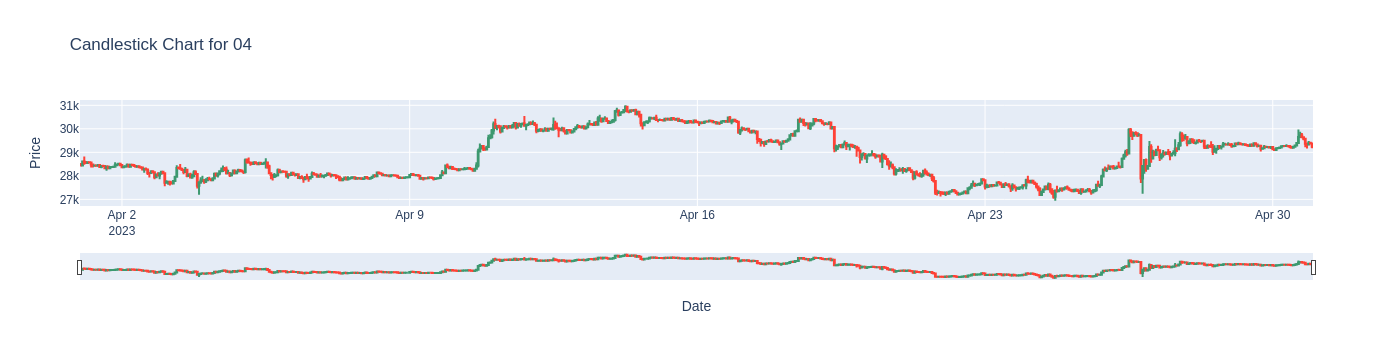

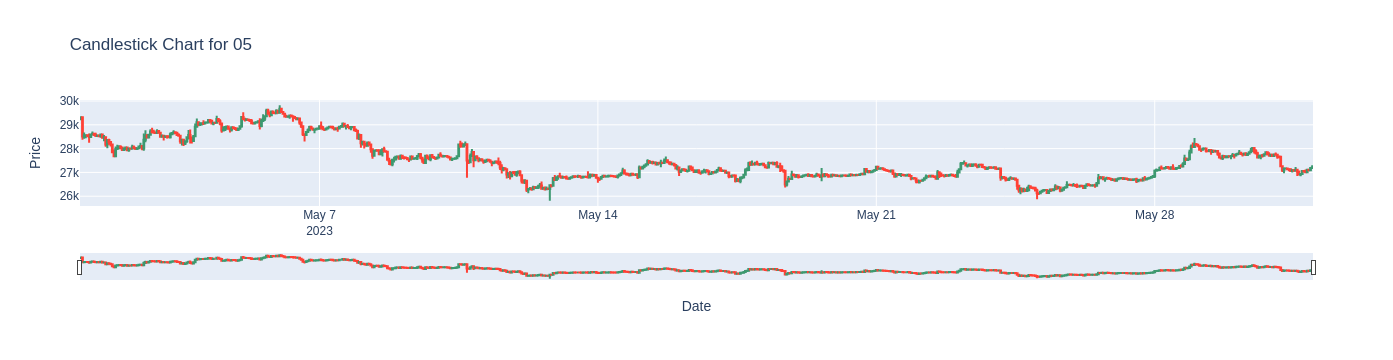

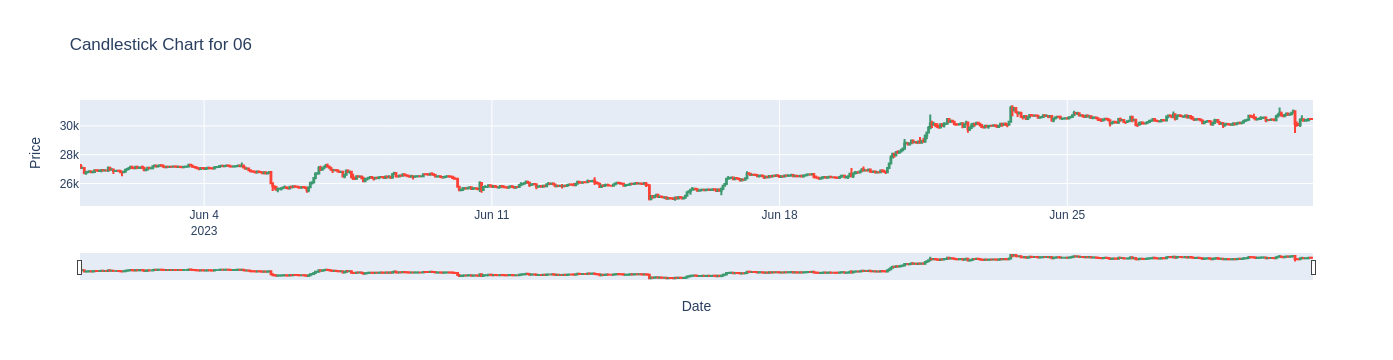

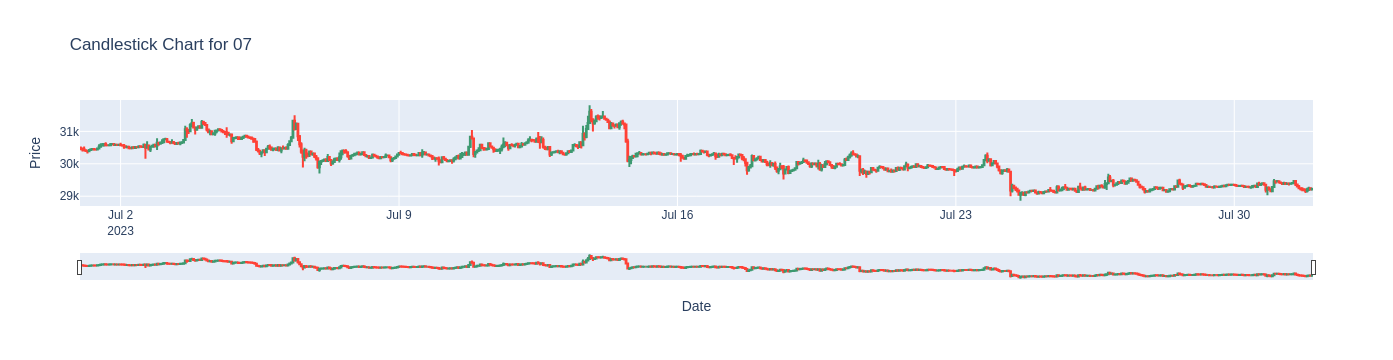

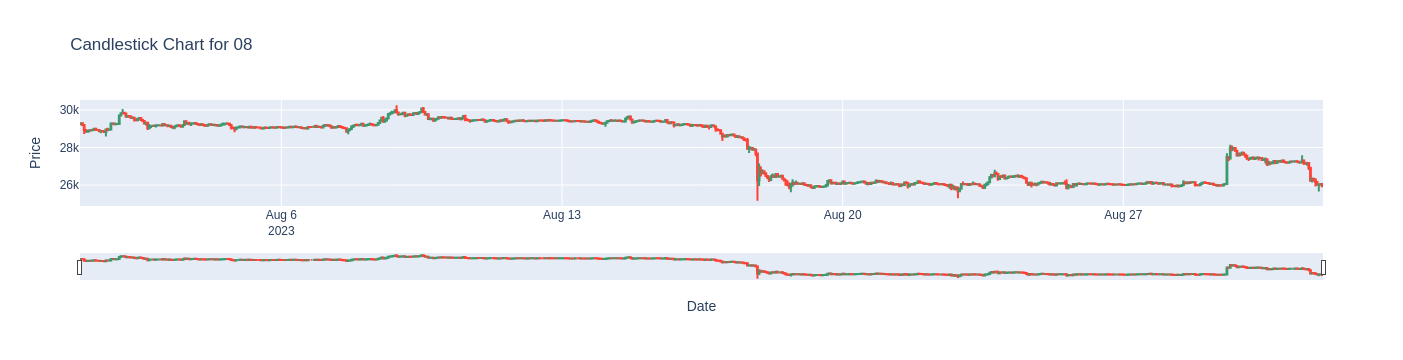

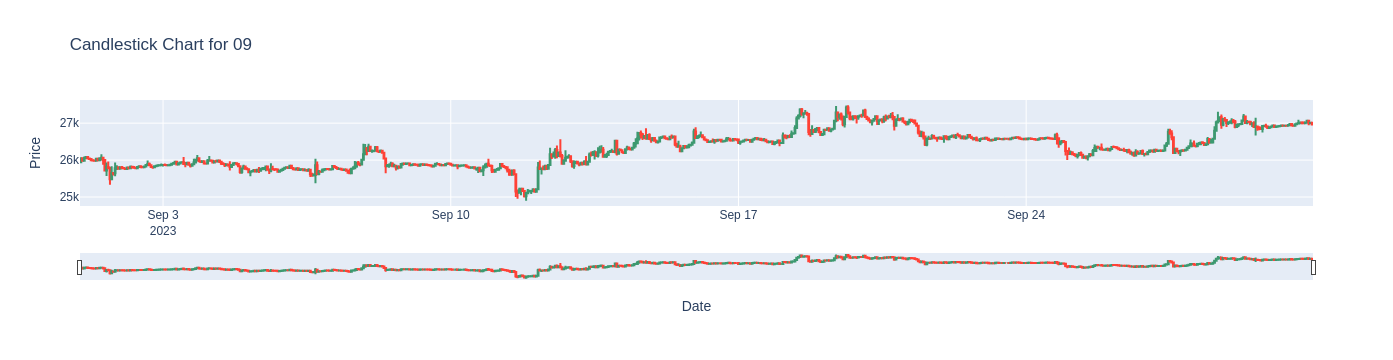

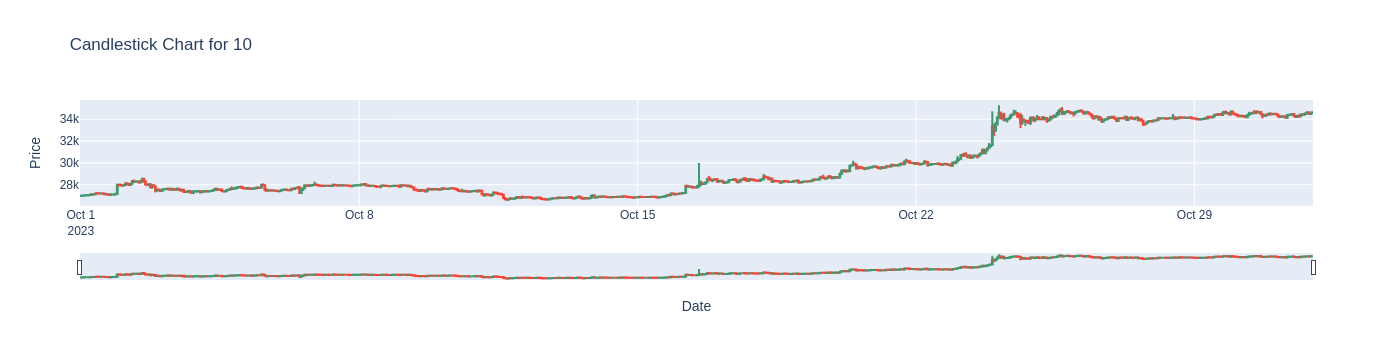

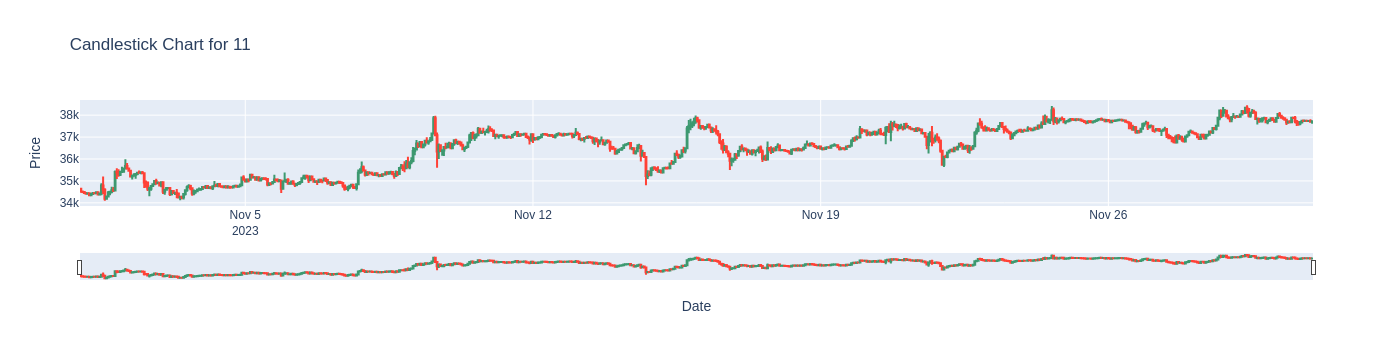

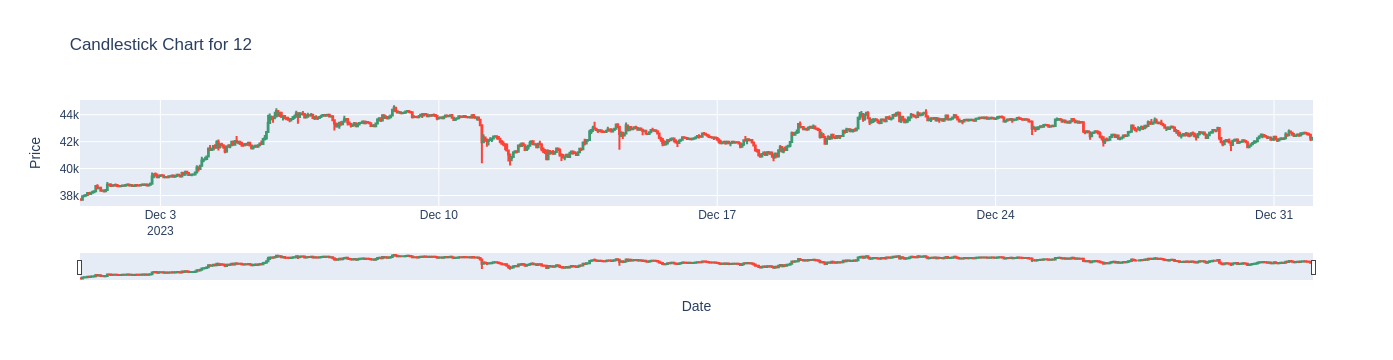

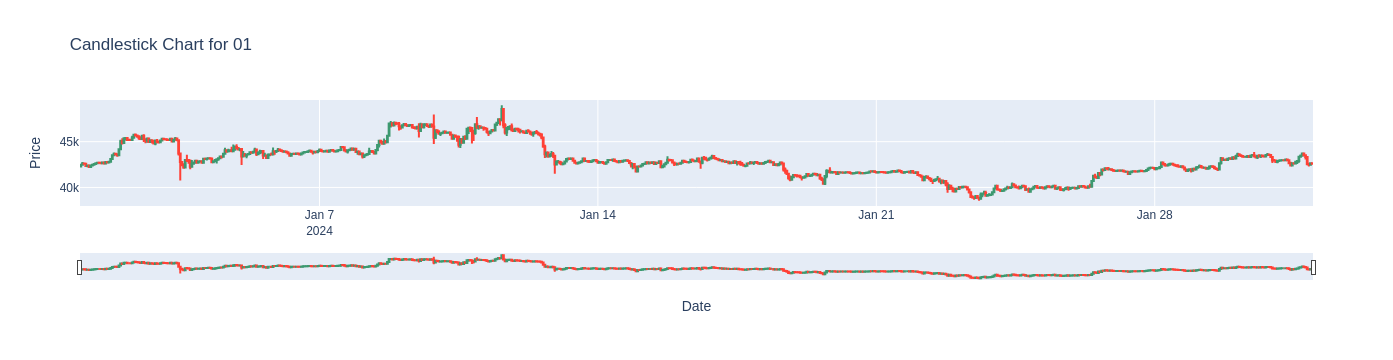

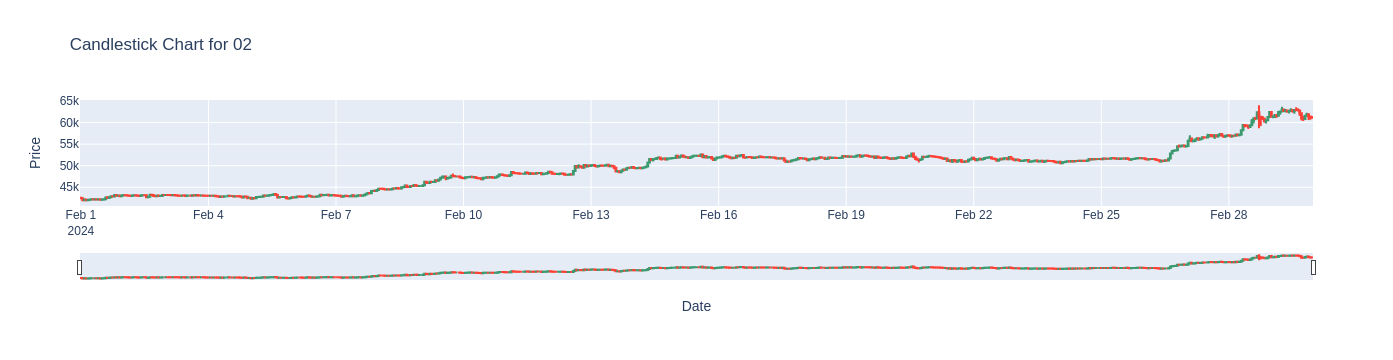

In [27]:
import plotly.graph_objects as go

months = train.index.month.unique()
for month in months[1:]:
    # Filter data for the specific month and year
    monthly_data = train[(train.index.month == month)]
    # Check if there is data for the month
    if not monthly_data.empty:
        # Create a candlestick chart for the month
        fig = go.Figure(data=[go.Candlestick(x=monthly_data.index,
                                             open=monthly_data['open'],
                                             high=monthly_data['high'],
                                             low=monthly_data['low'],
                                             close=monthly_data['close'])])
        # Update layout with the title indicating the month and year
        fig.update_layout(title=f'Candlestick Chart for {month:02d}',
                          xaxis_title='Date',
                          yaxis_title='Price')
        # Show the plot
        fig.show()

In [28]:
import optuna
import numpy as np
from backtest.ffn import calc_interval_return, calc_interval_volatility, calc_interval_downward_volatility, calc_mdd

class ObjectiveHandler:
    def __init__(self, p: np.array, market: pd.DataFrame, *features):
        self.features = list(features)
        self.p = p
        self.market = market
        self.r = calc_interval_return(market, 'open_time', 'close', '365d')
        self.volitility = calc_interval_volatility(market, 'open_time', 'close', '365d')
        self.volitility_d = calc_interval_downward_volatility(market, 'open_time', 'close', '365d')
        self.mdd = calc_mdd(market, 'close')
        

    def spot_statistics(self, u, v):  # Should be more general
        signal = self.spot_strategy(u, v)
        portfolio = self.spot_run(signal)
        stats = self._calc_stats(portfolio)
        return stats

    def market_return(self):
        return self.r

    def market_volatility(self):
        return self.volitility

    def market_volatility_d(self):
        return self.volitility_d
        
    def spot_strategy(self, u, v):
        u = u / np.sqrt(u @ u)
        v = v / np.sqrt(v @ v)
        df = self.market.copy()
        df['buy'] = df[self.features] @ u
        df['sell'] = df[self.features] @ v
        df['buy_signal'] = df['buy'] > 0
        df['sell_signal'] = df['sell'] > 0
        # Apply logic to create strategy column
        df['strategy'] = df.apply(
            lambda row: "Buy" if row['buy_signal'] == True and row['sell_signal'] == False 
                        else ("Sell" if row['buy_signal'] == False and row['sell_signal'] == True 
                              else "Hold"), 
            axis=1
        )
        return df

    def spot_run(self, strategy: pd.DataFrame):
        eps = 1e-5
        asset = {'token': 1_000 / strategy['open'].iloc[0], 'usdt': 1_000}
        portfolio = []
        for idx, event in strategy.iterrows():
            price = event["close"]
            if event["strategy"] == "Hold":
                pass
            elif asset['usdt'] > eps and event["strategy"] == "Buy":
                usdt_amt = asset['usdt']
                btc_amt = usdt_amt / price
                asset['token'] += btc_amt
                asset['usdt'] -= usdt_amt
            elif asset['token'] > eps / price and event["strategy"] == "Sell":
                btc_amt = asset['token']
                usdt_amt = btc_amt * price
                asset['token'] -= btc_amt
                asset['usdt'] += usdt_amt
            portfolio.append({"open_time": event["open_time"]} | asset | {"value": asset["token"] * price + asset["usdt"]})
        portfolio = pd.DataFrame(portfolio)
        return portfolio
        
        

    def _calc_stats(self, portfolio: pd.DataFrame):
        # Calc interest index
        r = calc_interval_return(portfolio, 'open_time', 'value', '365d')
        volitility = calc_interval_volatility(portfolio, 'open_time', 'value', '365d')
        volitility_d = calc_interval_downward_volatility(portfolio, 'open_time', 'value', '365d')
        mdd = calc_mdd(portfolio, 'value')
        return {
            "return": r,
            "volatility": volitility,
            "volatility_d": volitility_d,
            "mdd": mdd
        }


In [29]:
p = train[['macd', 'macdsignal']].mean().to_numpy()

In [30]:
# Test EMA CS
def objective(trial):
    # Suggest values for a 2-dimensional x
    x1 = trial.suggest_float('x1', -1, 1)
    x2 = trial.suggest_float('x2', -1, 1)
    
    # Create the vector x
    x = np.array([x1, x2])
    
    # Compute x^T x
    return x.T @ x

# Create a study, specifying the CMA-ES sampler
sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-06-01 16:44:26,737] A new study created in memory with name: no-name-01dfe896-7bd4-47f7-8614-9307f56217d1
[I 2024-06-01 16:44:26,739] Trial 0 finished with value: 1.6024000189044212 and parameters: {'x1': -0.9925854143039579, 'x2': 0.7856043623958955}. Best is trial 0 with value: 1.6024000189044212.
[I 2024-06-01 16:44:26,740] Trial 1 finished with value: 0.268885538467078 and parameters: {'x1': -0.49672933416689635, 'x2': 0.14881366551896313}. Best is trial 1 with value: 0.268885538467078.
[I 2024-06-01 16:44:26,741] Trial 2 finished with value: 0.0855349040549169 and parameters: {'x1': 0.1175373548110088, 'x2': -0.26780566513602344}. Best is trial 2 with value: 0.0855349040549169.
[I 2024-06-01 16:44:26,742] Trial 3 finished with value: 0.11658599442035114 and parameters: {'x1': 0.07795853621777837, 'x2': -0.33242812915144904}. Best is trial 2 with value: 0.0855349040549169.
[I 2024-06-01 16:44:26,742] Trial 4 finished with value: 0.6714638784369105 and parameters: {'x1': -0.

In [31]:
# Initialize the handler with the training set
training_handler = ObjectiveHandler(p, train, 'macd', 'macdsignal')
testing_handler = ObjectiveHandler(p, test, 'macd', 'macdsignal')
trial_performance = {'training': [], 'testing': []}

def objective(trial):
    # Suggest values for a 2-dimensional x
    u1 = trial.suggest_float('u1', -1, 1)
    u2 = trial.suggest_float('u2', -1, 1)

    v1 = trial.suggest_float('v1', -1, 1)
    v2 = trial.suggest_float('v2', -1, 1)
    
    # Create the vector x
    u = np.array([u1, u2])
    v = np.array([v1, v2])
    training_stats = training_handler.spot_statistics(u, v)
    testing_stats = testing_handler.spot_statistics(u, v)

    # Store performances
    panalty = 2
    # testing performance
    upside = testing_stats["return"] - testing_handler.market_return()
    downside = np.sqrt(testing_stats["volatility_d"] ** 2 + testing_handler.market_volatility_d() ** 2)
    target = upside / (panalty * downside)
    trial_performance['testing'].append(testing_stats | {"target": target})
    # training performance
    upside = training_stats["return"] - training_handler.market_return()
    downside = np.sqrt(training_stats["volatility_d"] ** 2 + training_handler.market_volatility_d() ** 2)
    target = upside / (panalty * downside)
    trial_performance['training'].append(training_stats | {"target": target})
    return target

def print_testing_performance(study, trial):
    latest_testing_stats = trial_performance['testing'][-1]
    print(f"Trial {trial.number}, Testing Set Performance: {latest_testing_stats}")

    

# Create a study, specifying the CMA-ES sampler
sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler, direction='maximize')
 
# Optimize the objective function
study.optimize(objective, n_trials=100, callbacks=[print_testing_performance])

[I 2024-06-01 16:44:29,606] A new study created in memory with name: no-name-bc848ba1-cbdf-4766-9b13-92eb8866bc2b
[I 2024-06-01 16:44:30,033] Trial 0 finished with value: -0.9401074063108791 and parameters: {'u1': 0.4923917881362072, 'u2': -0.9868376169375421, 'v1': 0.23883675241451163, 'v2': 0.5643697230467553}. Best is trial 0 with value: -0.9401074063108791.


Trial 0, Testing Set Performance: {'return': 0.8221114842074432, 'volatility': 0.46370295458779415, 'volatility_d': 0.7379518145462934, 'mdd': 0.14900770270172273, 'target': 0.48150241983069964}


[I 2024-06-01 16:44:30,453] Trial 1 finished with value: -0.6756536004461411 and parameters: {'u1': 0.7367725601776043, 'u2': 0.3020219555999524, 'v1': 0.2511910483731796, 'v2': 0.616546434233098}. Best is trial 1 with value: -0.6756536004461411.


Trial 1, Testing Set Performance: {'return': -0.632549396447447, 'volatility': 0.38225230669872196, 'volatility_d': 0.6865294568850656, 'mdd': 0.19763688220245956, 'target': -0.2607774246821015}


[I 2024-06-01 16:44:30,879] Trial 2 finished with value: -0.5615092512197309 and parameters: {'u1': 0.1381623739511708, 'u2': 0.05992467969963311, 'v1': -0.12504994424376592, 'v2': 0.14193161818575217}. Best is trial 2 with value: -0.5615092512197309.


Trial 2, Testing Set Performance: {'return': -0.6190577820407717, 'volatility': 0.38990690378227183, 'volatility_d': 0.5722567383180509, 'mdd': 0.18227593807487247, 'target': -0.2764276445671545}


[I 2024-06-01 16:44:31,315] Trial 3 finished with value: -0.5703033829132708 and parameters: {'u1': 0.19289313061573532, 'u2': 0.5468178207957526, 'v1': -0.6042236902665894, 'v2': 0.32488906066577883}. Best is trial 2 with value: -0.5615092512197309.


Trial 3, Testing Set Performance: {'return': -0.6124796943343432, 'volatility': 0.3977094191574589, 'volatility_d': 0.5718261577014583, 'mdd': 0.19318189459932095, 'target': -0.272764577643347}


[I 2024-06-01 16:44:31,735] Trial 4 finished with value: -0.8835989578744258 and parameters: {'u1': -0.07366360776892023, 'u2': 0.4352145313903424, 'v1': 0.0021154398671576757, 'v2': 0.050598028259338346}. Best is trial 2 with value: -0.5615092512197309.


Trial 4, Testing Set Performance: {'return': 0.5667201419488165, 'volatility': 0.4899725892598415, 'volatility_d': 0.7282292024885415, 'mdd': 0.15239623289778131, 'target': 0.3554939190669266}


[I 2024-06-01 16:44:32,172] Trial 5 finished with value: -0.7141680173250091 and parameters: {'u1': 0.28167601849839263, 'u2': -0.4768427880734144, 'v1': -0.23797065229190617, 'v2': 0.05839595370795814}. Best is trial 2 with value: -0.5615092512197309.


Trial 5, Testing Set Performance: {'return': -0.7628239246773184, 'volatility': 0.35152753677596116, 'volatility_d': 0.5617297841327678, 'mdd': 0.20406086563133954, 'target': -0.36120883508200297}


[I 2024-06-01 16:44:32,594] Trial 6 finished with value: -0.1515818023199229 and parameters: {'u1': 0.05139827685748344, 'u2': 0.6392489168749256, 'v1': -0.04060499729812361, 'v2': 0.7705129046582531}. Best is trial 6 with value: -0.1515818023199229.


Trial 6, Testing Set Performance: {'return': -0.7040205687206111, 'volatility': 0.38302986438622505, 'volatility_d': 0.5938998627712969, 'mdd': 0.213352840724308, 'target': -0.31966549062573385}


[I 2024-06-01 16:44:33,088] Trial 7 finished with value: -0.7825684136199184 and parameters: {'u1': -0.6402389988867564, 'u2': -0.40854336347503206, 'v1': 0.1597375463970363, 'v2': -0.1351428713310503}. Best is trial 6 with value: -0.1515818023199229.


Trial 7, Testing Set Performance: {'return': 0.21042647831115688, 'volatility': 0.47405642954811295, 'volatility_d': 0.7598465154515669, 'mdd': 0.15979977381442392, 'target': 0.17070960701342228}


[I 2024-06-01 16:44:33,532] Trial 8 finished with value: -0.7485392313075808 and parameters: {'u1': -0.6466361297532459, 'u2': 0.007829500945179646, 'v1': 0.26482579393777983, 'v2': 0.14507964778583915}. Best is trial 6 with value: -0.1515818023199229.


Trial 8, Testing Set Performance: {'return': 0.2936149873138394, 'volatility': 0.4758088047506256, 'volatility_d': 0.767473740274744, 'mdd': 0.14040025908461928, 'target': 0.21071369803871626}


[I 2024-06-01 16:44:33,961] Trial 9 finished with value: -0.8099490184562602 and parameters: {'u1': -0.22805182692188453, 'u2': 0.7335098426293183, 'v1': 0.13864038645228205, 'v2': 0.802817012898033}. Best is trial 6 with value: -0.1515818023199229.


Trial 9, Testing Set Performance: {'return': 0.4018469938040003, 'volatility': 0.4793449350023718, 'volatility_d': 0.7609158703911392, 'mdd': 0.13323569923059184, 'target': 0.2653128583918456}


[I 2024-06-01 16:44:34,412] Trial 10 finished with value: -0.5778197167634509 and parameters: {'u1': 0.7919926662519239, 'u2': 0.4360222731278154, 'v1': -0.7747306817978495, 'v2': 0.20960395670944587}. Best is trial 6 with value: -0.1515818023199229.


Trial 10, Testing Set Performance: {'return': -0.40819840994519685, 'volatility': 0.4026817923507502, 'volatility_d': 0.5735114910225596, 'mdd': 0.1650152949834717, 'target': -0.15606228359586524}


[I 2024-06-01 16:44:34,926] Trial 11 finished with value: -0.47197834891927387 and parameters: {'u1': -0.028525974859873626, 'u2': 0.9523600189365546, 'v1': -0.15879203006846832, 'v2': 0.3866605604489839}. Best is trial 6 with value: -0.1515818023199229.


Trial 11, Testing Set Performance: {'return': -0.6920290704884036, 'volatility': 0.4007741056657297, 'volatility_d': 0.5712977694570939, 'mdd': 0.18897227272494335, 'target': -0.3182585468809948}


[I 2024-06-01 16:44:35,362] Trial 12 finished with value: -0.6251887598498262 and parameters: {'u1': 0.20340157621757982, 'u2': -0.030635081124676944, 'v1': -0.1896826049602589, 'v2': -0.050497949468000014}. Best is trial 6 with value: -0.1515818023199229.


Trial 12, Testing Set Performance: {'return': -0.5921103680826207, 'volatility': 0.3895452455049707, 'volatility_d': 0.5696546312213274, 'mdd': 0.177411822937895, 'target': -0.26156959741376995}


[I 2024-06-01 16:44:35,780] Trial 13 finished with value: -0.44757275939163504 and parameters: {'u1': 0.28268204620498016, 'u2': 0.3257310846751802, 'v1': -0.04404776338593863, 'v2': 0.7704650511678266}. Best is trial 6 with value: -0.1515818023199229.


Trial 13, Testing Set Performance: {'return': -0.4876497095006906, 'volatility': 0.415556859463093, 'volatility_d': 0.5804739433770586, 'mdd': 0.18314070409849426, 'target': -0.2002769690645006}


[I 2024-06-01 16:44:36,212] Trial 14 finished with value: -0.764715908469497 and parameters: {'u1': 0.9049286559032619, 'u2': 0.4973777492721345, 'v1': 0.5682990393294194, 'v2': 0.3809250925862582}. Best is trial 6 with value: -0.1515818023199229.


Trial 14, Testing Set Performance: {'return': 0.2316238733859539, 'volatility': 0.41449759557963045, 'volatility_d': 0.5414653526315489, 'mdd': 0.11540212812111454, 'target': 0.2133925746085696}


[I 2024-06-01 16:44:36,685] Trial 15 finished with value: -0.46571382585371734 and parameters: {'u1': -0.02352412003277282, 'u2': 0.24415777265274174, 'v1': -0.009516603717312555, 'v2': -0.01655735191498342}. Best is trial 6 with value: -0.1515818023199229.


Trial 15, Testing Set Performance: {'return': -0.6679984289431898, 'volatility': 0.40179611084954797, 'volatility_d': 0.5701919118969487, 'mdd': 0.185294700057426, 'target': -0.3047985128997221}


[I 2024-06-01 16:44:37,112] Trial 16 finished with value: -0.912846804505031 and parameters: {'u1': -0.2955483702799, 'u2': 0.23483634739232184, 'v1': -0.23362581106530755, 'v2': 0.6357182372245387}. Best is trial 6 with value: -0.1515818023199229.


Trial 16, Testing Set Performance: {'return': 0.9568171082884129, 'volatility': 0.4650993417517683, 'volatility_d': 0.7420154550208399, 'mdd': 0.13639881052694136, 'target': 0.5476580855162485}


[I 2024-06-01 16:44:37,553] Trial 17 finished with value: -0.5124268224716099 and parameters: {'u1': 0.05090681825701737, 'u2': 0.46545207465414484, 'v1': -0.19983970073048807, 'v2': -0.0033953473516694643}. Best is trial 6 with value: -0.1515818023199229.


Trial 17, Testing Set Performance: {'return': -0.5792412727698305, 'volatility': 0.3990831218995539, 'volatility_d': 0.5716525353450983, 'mdd': 0.18012070506649866, 'target': -0.25384070645629414}


[I 2024-06-01 16:44:37,982] Trial 18 finished with value: -0.45256493500919576 and parameters: {'u1': 0.0036164713858315434, 'u2': 0.6924400540132143, 'v1': -0.14828327928746787, 'v2': 0.42693190887921206}. Best is trial 6 with value: -0.1515818023199229.


Trial 18, Testing Set Performance: {'return': -0.8093506233415515, 'volatility': 0.39682844122633987, 'volatility_d': 0.5705057351155238, 'mdd': 0.21231886587699614, 'target': -0.38542310417600795}


[I 2024-06-01 16:44:38,418] Trial 19 finished with value: -0.5720064712813363 and parameters: {'u1': 0.24246484305840665, 'u2': -0.19603335639568686, 'v1': -0.1763624417415819, 'v2': 0.292277458634443}. Best is trial 6 with value: -0.1515818023199229.


Trial 19, Testing Set Performance: {'return': -0.18846744448244218, 'volatility': 0.4235960931523866, 'volatility_d': 0.6607977248755647, 'mdd': 0.1771315940949687, 'target': -0.028944215986603263}


[I 2024-06-01 16:44:38,847] Trial 20 finished with value: -0.8661528749148394 and parameters: {'u1': -0.05630109603857314, 'u2': 0.40288082846000894, 'v1': 0.32651023687689085, 'v2': 0.2473213172887918}. Best is trial 6 with value: -0.1515818023199229.


Trial 20, Testing Set Performance: {'return': 0.21726074282971455, 'volatility': 0.4632993282652016, 'volatility_d': 0.7626317957606599, 'mdd': 0.16284255137988732, 'target': 0.17373364562213628}


[I 2024-06-01 16:44:39,281] Trial 21 finished with value: -1.1714571319109082 and parameters: {'u1': 0.4492469557976082, 'u2': 0.46323126968751804, 'v1': 0.5169634193645363, 'v2': 0.38783836933836713}. Best is trial 6 with value: -0.1515818023199229.


Trial 21, Testing Set Performance: {'return': -0.9682815851613659, 'volatility': 0.3882849368636648, 'volatility_d': 0.7773503041608248, 'mdd': 0.18556682577363162, 'target': -0.4077821611368213}


[I 2024-06-01 16:44:39,785] Trial 22 finished with value: -0.9059133545036732 and parameters: {'u1': -0.0376519500061574, 'u2': 0.7228151720216884, 'v1': -0.1506803357396489, 'v2': 0.7945453640385969}. Best is trial 6 with value: -0.1515818023199229.


Trial 22, Testing Set Performance: {'return': -0.6848512631816432, 'volatility': 0.4202038544737115, 'volatility_d': 0.6400528898567553, 'mdd': 0.1686468965072102, 'target': -0.2983993398600567}


[I 2024-06-01 16:44:40,199] Trial 23 finished with value: -0.4068004308312413 and parameters: {'u1': 0.16997680829275663, 'u2': 0.16865924057506732, 'v1': 0.17334372253720653, 'v2': 0.6118696623620612}. Best is trial 6 with value: -0.1515818023199229.


Trial 23, Testing Set Performance: {'return': -0.5443552265610532, 'volatility': 0.4198264664869797, 'volatility_d': 0.5804013775217979, 'mdd': 0.18723094598214432, 'target': -0.23242240976533948}


[I 2024-06-01 16:44:40,657] Trial 24 finished with value: -0.39136297361678585 and parameters: {'u1': -0.23231654984756767, 'u2': 0.8329053563571454, 'v1': -0.11931502113706538, 'v2': 0.029398279034081654}. Best is trial 6 with value: -0.1515818023199229.


Trial 24, Testing Set Performance: {'return': -0.7183567997521945, 'volatility': 0.41264885454570055, 'volatility_d': 0.5924814035621362, 'mdd': 0.20583422159975254, 'target': -0.3280559464712618}


[I 2024-06-01 16:44:41,143] Trial 25 finished with value: -0.8269277847031514 and parameters: {'u1': -0.27733106229372184, 'u2': 0.4672904977070975, 'v1': 0.026471081568842703, 'v2': 0.33791032235530194}. Best is trial 6 with value: -0.1515818023199229.


Trial 25, Testing Set Performance: {'return': 0.47302206301585437, 'volatility': 0.478967834857432, 'volatility_d': 0.7610452416827282, 'mdd': 0.13330059352701884, 'target': 0.3005103835152493}


[I 2024-06-01 16:44:41,586] Trial 26 finished with value: -0.6637255759691502 and parameters: {'u1': 0.35791197929288865, 'u2': 0.5705713106549886, 'v1': -0.02786553049886764, 'v2': 0.8176324312510403}. Best is trial 6 with value: -0.1515818023199229.


Trial 26, Testing Set Performance: {'return': -0.5932969757951763, 'volatility': 0.4006734359892133, 'volatility_d': 0.5759344064667704, 'mdd': 0.19904128601108564, 'target': -0.2610247575153371}


[I 2024-06-01 16:44:42,021] Trial 27 finished with value: -0.8795221528570568 and parameters: {'u1': -0.11026253591671642, 'u2': 0.6421515080101827, 'v1': 0.010850887503064621, 'v2': 0.28714493097652416}. Best is trial 6 with value: -0.1515818023199229.


Trial 27, Testing Set Performance: {'return': 0.5144926423497633, 'volatility': 0.47783503687802625, 'volatility_d': 0.758052285662575, 'mdd': 0.1485298009689332, 'target': 0.321750672214848}


[I 2024-06-01 16:44:42,477] Trial 28 finished with value: -0.5355765120154492 and parameters: {'u1': -0.07343727833794944, 'u2': 0.67248738552085, 'v1': 0.2981207078387045, 'v2': 0.04914499030186237}. Best is trial 6 with value: -0.1515818023199229.


Trial 28, Testing Set Performance: {'return': 0.4007831401166981, 'volatility': 0.5058797088506171, 'volatility_d': 0.6983922067743519, 'mdd': 0.13702795306958926, 'target': 0.2774799474982985}


[I 2024-06-01 16:44:42,915] Trial 29 finished with value: -0.29505028222988305 and parameters: {'u1': 0.1306101377234572, 'u2': 0.3887677725698906, 'v1': 0.1697669957208361, 'v2': 0.03858174968148509}. Best is trial 6 with value: -0.1515818023199229.


Trial 29, Testing Set Performance: {'return': 0.8877100909280987, 'volatility': 0.5165679089223757, 'volatility_d': 0.6789393291444485, 'mdd': 0.13072978668169147, 'target': 0.5378360739728714}


[I 2024-06-01 16:44:43,438] Trial 30 finished with value: -0.9130556599501369 and parameters: {'u1': 0.07231069645420285, 'u2': -0.17444453540513782, 'v1': 0.6194598094282355, 'v2': -0.3671933772293968}. Best is trial 6 with value: -0.1515818023199229.


Trial 30, Testing Set Performance: {'return': 0.961595540723164, 'volatility': 0.46327723027888196, 'volatility_d': 0.7364466431616238, 'mdd': 0.1352058400482396, 'target': 0.5523531755584149}


[I 2024-06-01 16:44:43,878] Trial 31 finished with value: -0.4081838196660342 and parameters: {'u1': -0.1692050897895102, 'u2': 0.4647560265745747, 'v1': -0.4659940338926307, 'v2': -0.15141277366858485}. Best is trial 6 with value: -0.1515818023199229.


Trial 31, Testing Set Performance: {'return': -0.9427625393473482, 'volatility': 0.41404224120363636, 'volatility_d': 0.6002118418988395, 'mdd': 0.2280154420662263, 'target': -0.4514652214743629}


[I 2024-06-01 16:44:44,336] Trial 32 finished with value: -0.812511371237444 and parameters: {'u1': -0.017699084793845188, 'u2': -0.12282110909506128, 'v1': -0.03258859037744788, 'v2': 0.5325558434507482}. Best is trial 6 with value: -0.1515818023199229.


Trial 32, Testing Set Performance: {'return': 0.5762905313440452, 'volatility': 0.4765472438739853, 'volatility_d': 0.7736023272514816, 'mdd': 0.1340981729157602, 'target': 0.34834322901156284}


[I 2024-06-01 16:44:44,786] Trial 33 finished with value: -0.557429152254708 and parameters: {'u1': 0.023848727709350204, 'u2': 0.03150673717537433, 'v1': -0.3446071136186547, 'v2': 0.787564148618811}. Best is trial 6 with value: -0.1515818023199229.


Trial 33, Testing Set Performance: {'return': -0.5306844196399154, 'volatility': 0.4046386705619198, 'volatility_d': 0.5782891038765768, 'mdd': 0.18994167513905802, 'target': -0.225029279381439}


[I 2024-06-01 16:44:45,242] Trial 34 finished with value: -0.49732519670303155 and parameters: {'u1': 0.12216068653836265, 'u2': 0.10379656071943533, 'v1': -0.2845617522446292, 'v2': -0.06249526029858832}. Best is trial 6 with value: -0.1515818023199229.


Trial 34, Testing Set Performance: {'return': -0.4395299913995433, 'volatility': 0.4053562250984599, 'volatility_d': 0.5765745938059916, 'mdd': 0.1686779816852961, 'target': -0.1735128317285237}


[I 2024-06-01 16:44:45,692] Trial 35 finished with value: -0.8012538683183072 and parameters: {'u1': 0.3633018557419012, 'u2': 0.06319966697927049, 'v1': 0.04365302983102759, 'v2': 0.3125741179378996}. Best is trial 6 with value: -0.1515818023199229.


Trial 35, Testing Set Performance: {'return': -0.5605972443154507, 'volatility': 0.35509329672876866, 'volatility_d': 0.6147066106639957, 'mdd': 0.174019968850729, 'target': -0.23550477161134073}


[I 2024-06-01 16:44:46,142] Trial 36 finished with value: -0.5079857770860939 and parameters: {'u1': 0.2538689036135837, 'u2': 0.350973319076725, 'v1': -0.1594944675011536, 'v2': 0.2531015332008473}. Best is trial 6 with value: -0.1515818023199229.


Trial 36, Testing Set Performance: {'return': -0.42256718417825756, 'volatility': 0.40288846511215953, 'volatility_d': 0.5771800726727102, 'mdd': 0.17422877613488888, 'target': -0.1637987821192217}


[I 2024-06-01 16:44:46,585] Trial 37 finished with value: -1.2443638599020908 and parameters: {'u1': 0.22716544750988055, 'u2': 0.5022922551289359, 'v1': 0.1704845721780066, 'v2': 0.3434066606119375}. Best is trial 6 with value: -0.1515818023199229.


Trial 37, Testing Set Performance: {'return': 0.4193693245118372, 'volatility': 0.23573535525840633, 'volatility_d': 0.38287005372453864, 'mdd': 0.0885148302091184, 'target': 0.3609052657862003}


[I 2024-06-01 16:44:47,088] Trial 38 finished with value: -0.9014638704594171 and parameters: {'u1': 0.2681505878798629, 'u2': -0.05202962731837679, 'v1': 0.61693695356613, 'v2': 0.22812248396709878}. Best is trial 6 with value: -0.1515818023199229.


Trial 38, Testing Set Performance: {'return': -0.16297981859711846, 'volatility': 0.2996926563240322, 'volatility_d': 0.540943247245912, 'mdd': 0.11822478152302617, 'target': -0.016783678423650403}


[I 2024-06-01 16:44:47,525] Trial 39 finished with value: -0.5323096600882126 and parameters: {'u1': 0.49636222588851364, 'u2': 0.6501707260464042, 'v1': -0.3752946700422449, 'v2': -0.17517347475831258}. Best is trial 6 with value: -0.1515818023199229.


Trial 39, Testing Set Performance: {'return': -0.46780535086651714, 'volatility': 0.4037076175051719, 'volatility_d': 0.5761038948245792, 'mdd': 0.1795977545915284, 'target': -0.18964851201420507}


[I 2024-06-01 16:44:47,970] Trial 40 finished with value: -0.5918540141500759 and parameters: {'u1': -0.03823618903754289, 'u2': -0.014446769088080513, 'v1': 0.01604832732262773, 'v2': -0.49677689146790915}. Best is trial 6 with value: -0.1515818023199229.


Trial 40, Testing Set Performance: {'return': 0.8682145145561805, 'volatility': 0.49654212719244545, 'volatility_d': 0.6737726109758222, 'mdd': 0.13169861884656842, 'target': 0.5296302251147946}


[I 2024-06-01 16:44:48,410] Trial 41 finished with value: -0.612028636141227 and parameters: {'u1': 0.5998044701172143, 'u2': 0.18722465206301608, 'v1': -0.40127023258644057, 'v2': 0.23517967448203425}. Best is trial 6 with value: -0.1515818023199229.


Trial 41, Testing Set Performance: {'return': -0.6098137702325519, 'volatility': 0.3906925801912841, 'volatility_d': 0.5728534448667425, 'mdd': 0.18005360482084895, 'target': -0.2710368802707061}


[I 2024-06-01 16:44:48,859] Trial 42 finished with value: -0.6862650893369342 and parameters: {'u1': 0.586712586582609, 'u2': -0.14010828042026402, 'v1': -0.3891882434729075, 'v2': 0.0911101202554867}. Best is trial 6 with value: -0.1515818023199229.


Trial 42, Testing Set Performance: {'return': -0.29951579956543617, 'volatility': 0.3758998738495025, 'volatility_d': 0.5404744891213066, 'mdd': 0.13427538774745326, 'target': -0.09648819644294644}


[I 2024-06-01 16:44:49,336] Trial 43 finished with value: -0.5589534494038598 and parameters: {'u1': 0.017929500485456273, 'u2': 0.06981080667982953, 'v1': -0.28445447199692886, 'v2': -0.10512973929533687}. Best is trial 6 with value: -0.1515818023199229.


Trial 43, Testing Set Performance: {'return': -0.5720340591924092, 'volatility': 0.3982308058679833, 'volatility_d': 0.5707209970027585, 'mdd': 0.1869132984366162, 'target': -0.24990283848218292}


[I 2024-06-01 16:44:49,788] Trial 44 finished with value: -0.7254886007103589 and parameters: {'u1': 0.22923016656812756, 'u2': -0.4021247853008878, 'v1': -0.4058632995514544, 'v2': 0.3861904924896964}. Best is trial 6 with value: -0.1515818023199229.


Trial 44, Testing Set Performance: {'return': 0.17626405810689294, 'volatility': 0.4462469011753037, 'volatility_d': 0.6828809459679, 'mdd': 0.11110619227630261, 'target': 0.1629211377088603}


[I 2024-06-01 16:44:50,234] Trial 45 finished with value: -0.008005487263585477 and parameters: {'u1': 0.1217957952440969, 'u2': 0.04919003952511858, 'v1': 0.21988210501575045, 'v2': -0.08453372458607267}. Best is trial 45 with value: -0.008005487263585477.


Trial 45, Testing Set Performance: {'return': 0.44945728186187833, 'volatility': 0.5310108010102462, 'volatility_d': 0.6953673751898685, 'mdd': 0.1722449725133237, 'target': 0.3034139640980728}


[I 2024-06-01 16:44:50,755] Trial 46 finished with value: -0.5040292984312672 and parameters: {'u1': 0.5152760589492911, 'u2': 0.45572445701477715, 'v1': -0.12438186570491094, 'v2': -0.029497174889744904}. Best is trial 45 with value: -0.008005487263585477.


Trial 46, Testing Set Performance: {'return': -0.4656405183825225, 'volatility': 0.40558335182989974, 'volatility_d': 0.5769545236880786, 'mdd': 0.17250962465552935, 'target': -0.1882984362896803}


[I 2024-06-01 16:44:51,210] Trial 47 finished with value: -0.27934223226018523 and parameters: {'u1': -0.24193573211124542, 'u2': 0.5148183488478701, 'v1': -0.13219637331598943, 'v2': -0.22727122948984235}. Best is trial 45 with value: -0.008005487263585477.


Trial 47, Testing Set Performance: {'return': -0.9138813057850432, 'volatility': 0.41853388060252306, 'volatility_d': 0.6061113589589506, 'mdd': 0.23010730524450723, 'target': -0.43341979133849184}


[I 2024-06-01 16:44:51,684] Trial 48 finished with value: -0.44934425019605245 and parameters: {'u1': -0.06391638910523523, 'u2': 0.5388223187599477, 'v1': -0.3981023457841778, 'v2': -0.17042545459671388}. Best is trial 45 with value: -0.008005487263585477.


Trial 48, Testing Set Performance: {'return': -0.6118382676898947, 'volatility': 0.40162295014104926, 'volatility_d': 0.5698360404036186, 'mdd': 0.1768786753096015, 'target': -0.27280227061106055}


[I 2024-06-01 16:44:52,153] Trial 49 finished with value: -0.4082745279919531 and parameters: {'u1': -0.13891374815581525, 'u2': 0.38761634488260843, 'v1': -0.23797789004295422, 'v2': -0.3485390052534161}. Best is trial 45 with value: -0.008005487263585477.


Trial 49, Testing Set Performance: {'return': -0.9692132580964734, 'volatility': 0.4138998008617391, 'volatility_d': 0.5993053015437712, 'mdd': 0.23197136377181182, 'target': -0.4665508838057305}


[I 2024-06-01 16:44:52,601] Trial 50 finished with value: -0.4782086762413983 and parameters: {'u1': 0.08641311489595105, 'u2': 0.028513297567216656, 'v1': -0.029308993094113278, 'v2': -0.5298555169479687}. Best is trial 45 with value: -0.008005487263585477.


Trial 50, Testing Set Performance: {'return': -0.7048940941616688, 'volatility': 0.3988662167736164, 'volatility_d': 0.5721793198399303, 'mdd': 0.19617520527086238, 'target': -0.3253851852439332}


[I 2024-06-01 16:44:53,048] Trial 51 finished with value: -0.552759989013883 and parameters: {'u1': -0.31654240400771816, 'u2': 0.222518667193075, 'v1': 0.050063842353418986, 'v2': -0.5623724079382475}. Best is trial 45 with value: -0.008005487263585477.


Trial 51, Testing Set Performance: {'return': 0.20412120134328518, 'volatility': 0.45643926723512745, 'volatility_d': 0.6492497328383822, 'mdd': 0.11796209780694471, 'target': 0.1820881454643513}


[I 2024-06-01 16:44:53,498] Trial 52 finished with value: -0.43345784558159367 and parameters: {'u1': 0.26625107360511246, 'u2': -0.08443274463611616, 'v1': 0.02397223412172833, 'v2': -0.22537697906792975}. Best is trial 45 with value: -0.008005487263585477.


Trial 52, Testing Set Performance: {'return': -0.604528166537052, 'volatility': 0.4016841352708269, 'volatility_d': 0.5706045310039487, 'mdd': 0.17578320138576523, 'target': -0.2684734929074078}


[I 2024-06-01 16:44:53,953] Trial 53 finished with value: -0.3617552980641301 and parameters: {'u1': -0.08349870121265379, 'u2': 0.200366699710266, 'v1': -0.03581311775562357, 'v2': -0.3812421439870999}. Best is trial 45 with value: -0.008005487263585477.


Trial 53, Testing Set Performance: {'return': -0.9556621778173889, 'volatility': 0.4160991388746292, 'volatility_d': 0.6029528701892155, 'mdd': 0.23630437085776085, 'target': -0.45772764778843583}


[I 2024-06-01 16:44:54,462] Trial 54 finished with value: -0.5151346399472104 and parameters: {'u1': 0.017493377556106582, 'u2': 0.1495593638396302, 'v1': -0.21278104915214313, 'v2': -0.4316008343669031}. Best is trial 45 with value: -0.008005487263585477.


Trial 54, Testing Set Performance: {'return': -0.5791485518434613, 'volatility': 0.39908313757761293, 'volatility_d': 0.5716532860743596, 'mdd': 0.1801069465143645, 'target': -0.25378767694567433}


[I 2024-06-01 16:44:54,914] Trial 55 finished with value: -0.8191255616427083 and parameters: {'u1': -0.1383442372506113, 'u2': -0.19697678129450136, 'v1': 0.2279872184549574, 'v2': -0.31699993578402574}. Best is trial 45 with value: -0.008005487263585477.


Trial 55, Testing Set Performance: {'return': 0.30984973529957505, 'volatility': 0.47547485750809726, 'volatility_d': 0.756771643509538, 'mdd': 0.17386851660231298, 'target': 0.22046123464722026}


[I 2024-06-01 16:44:55,367] Trial 56 finished with value: -0.36344460975294446 and parameters: {'u1': 0.12305093654250321, 'u2': 0.3603033801713942, 'v1': 0.29779378071743934, 'v2': -0.49949206470282803}. Best is trial 45 with value: -0.008005487263585477.


Trial 56, Testing Set Performance: {'return': -0.4837853685403008, 'volatility': 0.42071314225216516, 'volatility_d': 0.6076336383571606, 'mdd': 0.20277191702630892, 'target': -0.19410552399221}


[I 2024-06-01 16:44:55,818] Trial 57 finished with value: -0.5516940049784591 and parameters: {'u1': 0.02589594461216249, 'u2': 0.07720445403763598, 'v1': -0.18084619527023316, 'v2': -0.46493539626683256}. Best is trial 45 with value: -0.008005487263585477.


Trial 57, Testing Set Performance: {'return': -0.5829756946931944, 'volatility': 0.3979355639535922, 'volatility_d': 0.5720534636230382, 'mdd': 0.1888475638068848, 'target': -0.2558944689503416}


[I 2024-06-01 16:44:56,272] Trial 58 finished with value: -0.45251546236095663 and parameters: {'u1': 0.11564338585649803, 'u2': 0.3859806303774913, 'v1': 0.055127949585829006, 'v2': -0.5309446512616796}. Best is trial 45 with value: -0.008005487263585477.


Trial 58, Testing Set Performance: {'return': -0.604528166537052, 'volatility': 0.4016841352708269, 'volatility_d': 0.5706045310039487, 'mdd': 0.17578320138576523, 'target': -0.2684734929074078}


[I 2024-06-01 16:44:56,730] Trial 59 finished with value: -0.4110567783818292 and parameters: {'u1': -0.0031665901511293004, 'u2': 0.3812816006022768, 'v1': 0.11619976890401329, 'v2': -0.5181012962675252}. Best is trial 45 with value: -0.008005487263585477.


Trial 59, Testing Set Performance: {'return': -0.6967065429734821, 'volatility': 0.4052012246473274, 'volatility_d': 0.5828403397742533, 'mdd': 0.19465882870451343, 'target': -0.31817952959602747}


[I 2024-06-01 16:44:57,193] Trial 60 finished with value: -0.4607966193033522 and parameters: {'u1': 0.1985477295210234, 'u2': 0.2361605624186729, 'v1': 0.06356105501709552, 'v2': -0.6131225345797626}. Best is trial 45 with value: -0.008005487263585477.


Trial 60, Testing Set Performance: {'return': -0.604528166537052, 'volatility': 0.4016841352708269, 'volatility_d': 0.5706045310039487, 'mdd': 0.17578320138576523, 'target': -0.2684734929074078}


[I 2024-06-01 16:44:57,710] Trial 61 finished with value: -0.3841950806630857 and parameters: {'u1': -0.16865852210632304, 'u2': 0.2838284997410694, 'v1': 0.15188694667869074, 'v2': -0.7225733015113414}. Best is trial 45 with value: -0.008005487263585477.


Trial 61, Testing Set Performance: {'return': -0.5218297988178981, 'volatility': 0.41945552250396895, 'volatility_d': 0.6086880059068543, 'mdd': 0.20277191702630903, 'target': -0.21506051619041694}


[I 2024-06-01 16:44:58,154] Trial 62 finished with value: -0.4234111600669086 and parameters: {'u1': 0.11330144888962468, 'u2': 0.5452446014347925, 'v1': 0.1070118642798108, 'v2': -0.39078145987187984}. Best is trial 45 with value: -0.008005487263585477.


Trial 62, Testing Set Performance: {'return': -0.7664151014093616, 'volatility': 0.4119143668333868, 'volatility_d': 0.5929968814601094, 'mdd': 0.20583422159975237, 'target': -0.3549089519346516}


[I 2024-06-01 16:44:58,594] Trial 63 finished with value: -0.5450533534614058 and parameters: {'u1': 0.10783552809236441, 'u2': 0.2651270621947013, 'v1': -0.3837646202596702, 'v2': -0.017271544799648986}. Best is trial 45 with value: -0.008005487263585477.


Trial 63, Testing Set Performance: {'return': -0.7672809950148356, 'volatility': 0.400511381380397, 'volatility_d': 0.5773489417817588, 'mdd': 0.21569809631271183, 'target': -0.3595699029255896}


[I 2024-06-01 16:44:59,019] Trial 64 finished with value: -0.278547595429803 and parameters: {'u1': -0.25435878612032015, 'u2': 0.5669101051055716, 'v1': 0.10243032614764314, 'v2': -0.5090513832853524}. Best is trial 45 with value: -0.008005487263585477.


Trial 64, Testing Set Performance: {'return': -0.8587350860980836, 'volatility': 0.4177813806893093, 'volatility_d': 0.6055782087334376, 'mdd': 0.22192785074536675, 'target': -0.40292461028385884}


[I 2024-06-01 16:44:59,458] Trial 65 finished with value: -0.39547329513797275 and parameters: {'u1': -0.11240923120593482, 'u2': 0.4442368764629956, 'v1': -0.02799647484917389, 'v2': -0.12291545360303147}. Best is trial 45 with value: -0.008005487263585477.


Trial 65, Testing Set Performance: {'return': -0.6482738181848627, 'volatility': 0.40837628844343016, 'volatility_d': 0.5857785059779371, 'mdd': 0.1882580223848419, 'target': -0.29014608636073813}


[I 2024-06-01 16:44:59,903] Trial 66 finished with value: -0.49073686564602353 and parameters: {'u1': 0.033434120780854615, 'u2': 0.427471034815029, 'v1': -0.020962142775846848, 'v2': -0.5911052859696949}. Best is trial 45 with value: -0.008005487263585477.


Trial 66, Testing Set Performance: {'return': -0.7662418924915695, 'volatility': 0.39931654064176636, 'volatility_d': 0.572233293315258, 'mdd': 0.20530783675933167, 'target': -0.36034962109218127}


[I 2024-06-01 16:45:00,329] Trial 67 finished with value: -0.8277281534957701 and parameters: {'u1': -0.20388727573614007, 'u2': 0.5129245856696276, 'v1': -0.010826911495834812, 'v2': 0.22304397841135182}. Best is trial 45 with value: -0.008005487263585477.


Trial 67, Testing Set Performance: {'return': 0.5889903873406247, 'volatility': 0.47663349005370387, 'volatility_d': 0.764752769025925, 'mdd': 0.13250089535761655, 'target': 0.35691319859858367}


[I 2024-06-01 16:45:00,762] Trial 68 finished with value: -0.49177411727529324 and parameters: {'u1': -0.3752467188649049, 'u2': 0.6418123142427303, 'v1': 0.5509169535068799, 'v2': -0.8444116902767518}. Best is trial 45 with value: -0.008005487263585477.


Trial 68, Testing Set Performance: {'return': -0.7443193010721655, 'volatility': 0.43059293605857407, 'volatility_d': 0.6264265156453864, 'mdd': 0.20540963768525178, 'target': -0.3340293550080996}


[I 2024-06-01 16:45:01,257] Trial 69 finished with value: -0.5333522472503939 and parameters: {'u1': -0.3779604475229681, 'u2': 0.391684829099364, 'v1': 0.2118343872225461, 'v2': -0.5681134320688501}. Best is trial 45 with value: -0.008005487263585477.


Trial 69, Testing Set Performance: {'return': -0.308407477209107, 'volatility': 0.4382860319874595, 'volatility_d': 0.625688982321972, 'mdd': 0.13734969635071073, 'target': -0.09542169416873757}


[I 2024-06-01 16:45:01,743] Trial 70 finished with value: -0.2744769618112885 and parameters: {'u1': -0.04129016111032968, 'u2': 0.25077742547858994, 'v1': 0.1420894043016354, 'v2': -0.3065780988958797}. Best is trial 45 with value: -0.008005487263585477.


Trial 70, Testing Set Performance: {'return': -0.872234775617, 'volatility': 0.41781760850517535, 'volatility_d': 0.604792821594431, 'mdd': 0.2239301656238717, 'target': -0.41067371059544727}


[I 2024-06-01 16:45:02,201] Trial 71 finished with value: -0.31570924918053167 and parameters: {'u1': -0.2309408980638029, 'u2': 0.5063884142606259, 'v1': -0.002433852058211672, 'v2': -0.33554580681915036}. Best is trial 45 with value: -0.008005487263585477.


Trial 71, Testing Set Performance: {'return': -0.8710857272353325, 'volatility': 0.4178183051954235, 'volatility_d': 0.6048021576729916, 'mdd': 0.22375973528415827, 'target': -0.41003144937098646}


[I 2024-06-01 16:45:02,665] Trial 72 finished with value: -0.3820245504750324 and parameters: {'u1': -0.18658963518292182, 'u2': 0.9380234403405836, 'v1': 0.17210820236272362, 'v2': -0.6192707941209639}. Best is trial 45 with value: -0.008005487263585477.


Trial 72, Testing Set Performance: {'return': -0.7441588225454601, 'volatility': 0.41204829384379715, 'volatility_d': 0.5931729801590185, 'mdd': 0.20583422159975254, 'target': -0.3423694534135321}


[I 2024-06-01 16:45:03,119] Trial 73 finished with value: -0.2786365600467625 and parameters: {'u1': -0.3686888894484335, 'u2': 0.4152371978363132, 'v1': 0.12845429256595065, 'v2': -0.6592961526585464}. Best is trial 45 with value: -0.008005487263585477.


Trial 73, Testing Set Performance: {'return': -0.7272154374186512, 'volatility': 0.42872612236546803, 'volatility_d': 0.6276285371479401, 'mdd': 0.17275802090164946, 'target': -0.32437203594763764}


[I 2024-06-01 16:45:03,572] Trial 74 finished with value: -0.22328957554183707 and parameters: {'u1': -0.09851614631810601, 'u2': 0.15287547229151333, 'v1': 0.03635701706463368, 'v2': -0.3139980753343661}. Best is trial 45 with value: -0.008005487263585477.


Trial 74, Testing Set Performance: {'return': -0.5267445982388311, 'volatility': 0.4201565937069346, 'volatility_d': 0.608338765633016, 'mdd': 0.2070114795206979, 'target': -0.21784442440499144}


[I 2024-06-01 16:45:04,030] Trial 75 finished with value: -0.39544909351010094 and parameters: {'u1': -0.15893156470074454, 'u2': 0.5525222676271802, 'v1': 0.04839289114989698, 'v2': -0.43573182144879863}. Best is trial 45 with value: -0.008005487263585477.


Trial 75, Testing Set Performance: {'return': -0.7712010163805088, 'volatility': 0.41138959996223984, 'volatility_d': 0.5927452075375275, 'mdd': 0.20575265807919366, 'target': -0.3576629930117337}


[I 2024-06-01 16:45:04,498] Trial 76 finished with value: -0.4822258613910252 and parameters: {'u1': 0.12765747054949816, 'u2': 0.27723610711172575, 'v1': -0.004681178660928431, 'v2': -0.1602648766583884}. Best is trial 45 with value: -0.008005487263585477.


Trial 76, Testing Set Performance: {'return': -0.7396515761263727, 'volatility': 0.3983567347188087, 'volatility_d': 0.5700394657224029, 'mdd': 0.20715397012105655, 'target': -0.34575289810578025}


[I 2024-06-01 16:45:05,015] Trial 77 finished with value: -0.151026636640765 and parameters: {'u1': -0.10178620696161633, 'u2': 0.4276884780726793, 'v1': 0.47997862000744673, 'v2': -0.42781764707709424}. Best is trial 45 with value: -0.008005487263585477.


Trial 77, Testing Set Performance: {'return': -0.049254530591609925, 'volatility': 0.43153730748436386, 'volatility_d': 0.6144148142297708, 'mdd': 0.13855955159998565, 'target': 0.04693796269155345}


[I 2024-06-01 16:45:05,472] Trial 78 finished with value: -0.2858365738828542 and parameters: {'u1': -0.29726831618483085, 'u2': 0.6337501554328646, 'v1': 0.06555842835569092, 'v2': -0.6266648223432292}. Best is trial 45 with value: -0.008005487263585477.


Trial 78, Testing Set Performance: {'return': -0.8789510639663147, 'volatility': 0.41887261801883824, 'volatility_d': 0.6071646264042218, 'mdd': 0.22492634587463356, 'target': -0.41367527326679415}


[I 2024-06-01 16:45:05,923] Trial 79 finished with value: -0.3007432486068065 and parameters: {'u1': -0.13861428695798084, 'u2': 0.2827778862572923, 'v1': 0.1296463156473895, 'v2': -0.6542157628282204}. Best is trial 45 with value: -0.008005487263585477.


Trial 79, Testing Set Performance: {'return': -0.9739630216216679, 'volatility': 0.4188684903282512, 'volatility_d': 0.6048261730981425, 'mdd': 0.23867925921667746, 'target': -0.46726922453153585}


[I 2024-06-01 16:45:06,383] Trial 80 finished with value: -0.301313543885079 and parameters: {'u1': 0.10777927186331104, 'u2': 0.4063931939796155, 'v1': 0.05080965868452547, 'v2': -0.11184730023420553}. Best is trial 45 with value: -0.008005487263585477.


Trial 80, Testing Set Performance: {'return': -0.8710857272353325, 'volatility': 0.4178183051954235, 'volatility_d': 0.6048021576729916, 'mdd': 0.22375973528415827, 'target': -0.41003144937098646}


[I 2024-06-01 16:45:06,845] Trial 81 finished with value: -0.8919000938015925 and parameters: {'u1': -0.13878778607838904, 'u2': 0.09217072674357407, 'v1': 0.3724163227923494, 'v2': -0.40048107762054086}. Best is trial 45 with value: -0.008005487263585477.


Trial 81, Testing Set Performance: {'return': -0.07859520535216327, 'volatility': 0.5010422536035093, 'volatility_d': 0.7961986605714231, 'mdd': 0.15927479516213508, 'target': 0.02681641048680365}


[I 2024-06-01 16:45:07,307] Trial 82 finished with value: -0.888457105458623 and parameters: {'u1': -0.26811693904649914, 'u2': 0.2220711211472688, 'v1': 0.3250758349174361, 'v2': -0.2889983199632763}. Best is trial 45 with value: -0.008005487263585477.


Trial 82, Testing Set Performance: {'return': -0.23023123315127136, 'volatility': 0.4783279985870033, 'volatility_d': 0.7457777511913396, 'mdd': 0.187522255687052, 'target': -0.048060209659917225}


[I 2024-06-01 16:45:07,749] Trial 83 finished with value: -0.585838963277607 and parameters: {'u1': -0.0110864015598513, 'u2': 0.7413996452830462, 'v1': 0.6150262124691674, 'v2': -0.41145749415982347}. Best is trial 45 with value: -0.008005487263585477.


Trial 83, Testing Set Performance: {'return': -0.11527966972372959, 'volatility': 0.4698927246565691, 'volatility_d': 0.6644788253620815, 'mdd': 0.1449949443054778, 'target': 0.01007561207090544}


[I 2024-06-01 16:45:08,184] Trial 84 finished with value: -0.6122231141170282 and parameters: {'u1': -0.27293058651942737, 'u2': 0.1527938784363012, 'v1': 0.24922359271810168, 'v2': -0.39811786119640014}. Best is trial 45 with value: -0.008005487263585477.


Trial 84, Testing Set Performance: {'return': 0.3547816684768705, 'volatility': 0.5021519949483101, 'volatility_d': 0.7382135148025704, 'mdd': 0.13822541466106505, 'target': 0.24615800994783577}


[I 2024-06-01 16:45:08,696] Trial 85 finished with value: -0.6091422939421294 and parameters: {'u1': -0.16499082713436086, 'u2': 0.25964980164868434, 'v1': 0.278831789810875, 'v2': -0.028153706897173003}. Best is trial 45 with value: -0.008005487263585477.


Trial 85, Testing Set Performance: {'return': 0.39221441874705587, 'volatility': 0.5028237606364839, 'volatility_d': 0.7574586767843138, 'mdd': 0.1326292386001878, 'target': 0.261218064409377}


[I 2024-06-01 16:45:09,145] Trial 86 finished with value: -0.2593605890105813 and parameters: {'u1': -0.4388891463378204, 'u2': 0.6563882325801076, 'v1': 0.19425241460946152, 'v2': -0.891296093170831}. Best is trial 45 with value: -0.008005487263585477.


Trial 86, Testing Set Performance: {'return': -0.5009840479082047, 'volatility': 0.4191150323893171, 'volatility_d': 0.6059749445257964, 'mdd': 0.21357622200110152, 'target': -0.2039087410142545}


[I 2024-06-01 16:45:09,608] Trial 87 finished with value: -0.1279924728134809 and parameters: {'u1': -0.10772618752498464, 'u2': 0.31261599354109637, 'v1': 0.4106504641964297, 'v2': -0.3671031756115406}. Best is trial 45 with value: -0.008005487263585477.


Trial 87, Testing Set Performance: {'return': -0.09335298853726873, 'volatility': 0.44001559277448277, 'volatility_d': 0.619374177337131, 'mdd': 0.13855955159998568, 'target': 0.022491660137628003}


[I 2024-06-01 16:45:10,055] Trial 88 finished with value: -0.26254338222249357 and parameters: {'u1': -0.06916426301702538, 'u2': 0.41861976249245325, 'v1': 0.31652358682970005, 'v2': -0.5145770856801135}. Best is trial 45 with value: -0.008005487263585477.


Trial 88, Testing Set Performance: {'return': -0.577337186491557, 'volatility': 0.4188314779376974, 'volatility_d': 0.6067118046747909, 'mdd': 0.20279721369474205, 'target': -0.24622223922935632}


[I 2024-06-01 16:45:10,497] Trial 89 finished with value: -0.8162790849330533 and parameters: {'u1': -0.2825723557310771, 'u2': 0.25023405087928663, 'v1': 0.3236125670600689, 'v2': -0.4258942303001617}. Best is trial 45 with value: -0.008005487263585477.


Trial 89, Testing Set Performance: {'return': -0.1070515149638048, 'volatility': 0.4549675420323168, 'volatility_d': 0.6801831411979429, 'mdd': 0.13848165697367087, 'target': 0.014283665114546628}


[I 2024-06-01 16:45:10,952] Trial 90 finished with value: -0.42731783332566986 and parameters: {'u1': -0.037948922927129036, 'u2': 0.2880796485385575, 'v1': 0.5120978504284157, 'v2': -0.24700309705567647}. Best is trial 45 with value: -0.008005487263585477.


Trial 90, Testing Set Performance: {'return': 0.2782701059786106, 'volatility': 0.4987457064265119, 'volatility_d': 0.6967061141328068, 'mdd': 0.14535673024772205, 'target': 0.21420932409659638}


[I 2024-06-01 16:45:11,377] Trial 91 finished with value: -0.7331725085499405 and parameters: {'u1': -0.24068345978817007, 'u2': 0.3856237872344759, 'v1': 0.5099204310308023, 'v2': -0.2696426260595034}. Best is trial 45 with value: -0.008005487263585477.


Trial 91, Testing Set Performance: {'return': 0.4159413259883211, 'volatility': 0.5022962020274664, 'volatility_d': 0.7401551887405972, 'mdd': 0.12735030592562344, 'target': 0.2765432757333663}


[I 2024-06-01 16:45:11,806] Trial 92 finished with value: -0.14545714296101647 and parameters: {'u1': -0.05112053227980118, 'u2': 0.3545467172859049, 'v1': 0.35493987487152556, 'v2': -0.3315949817307906}. Best is trial 45 with value: -0.008005487263585477.


Trial 92, Testing Set Performance: {'return': -0.15273438382451635, 'volatility': 0.4307857390914689, 'volatility_d': 0.6164063026757157, 'mdd': 0.13682027711290756, 'target': -0.010214818038700219}


[I 2024-06-01 16:45:12,304] Trial 93 finished with value: -0.6783620989916715 and parameters: {'u1': -0.12825879688276476, 'u2': 0.5707808103298411, 'v1': 0.5461840400116134, 'v2': -0.4205714845633606}. Best is trial 45 with value: -0.008005487263585477.


Trial 93, Testing Set Performance: {'return': -0.1563707470546521, 'volatility': 0.4600349522209495, 'volatility_d': 0.6541651591280695, 'mdd': 0.1395570324804941, 'target': -0.01187883765535608}


[I 2024-06-01 16:45:12,742] Trial 94 finished with value: -0.5824828978635155 and parameters: {'u1': -0.22365598776285256, 'u2': 0.24095336914209775, 'v1': 0.4302987756517549, 'v2': -0.6502969551891999}. Best is trial 45 with value: -0.008005487263585477.


Trial 94, Testing Set Performance: {'return': -0.10291173700820382, 'volatility': 0.4607518289247727, 'volatility_d': 0.6550555345766611, 'mdd': 0.11955701008215433, 'target': 0.016774516079594435}


[I 2024-06-01 16:45:13,176] Trial 95 finished with value: -0.3304068562236541 and parameters: {'u1': -0.2981937407016626, 'u2': 0.6215280616541659, 'v1': -0.06429958191746366, 'v2': -0.7524773784239446}. Best is trial 45 with value: -0.008005487263585477.


Trial 95, Testing Set Performance: {'return': -0.9223791796330074, 'volatility': 0.41861554545626073, 'volatility_d': 0.6061361296926111, 'mdd': 0.2313677356579322, 'target': -0.43813567540177295}


[I 2024-06-01 16:45:13,613] Trial 96 finished with value: -0.22046418903980242 and parameters: {'u1': -0.2314163461854275, 'u2': 0.6066247711310648, 'v1': 0.3682918050208561, 'v2': -0.2897019187880485}. Best is trial 45 with value: -0.008005487263585477.


Trial 96, Testing Set Performance: {'return': -0.20217273463620275, 'volatility': 0.46764334541952834, 'volatility_d': 0.6552594755088182, 'mdd': 0.15680906320868276, 'target': -0.03640776829707428}


[I 2024-06-01 16:45:14,047] Trial 97 finished with value: -0.431667610640861 and parameters: {'u1': -0.37079442694021747, 'u2': 0.4598227593402531, 'v1': 0.2854330258092508, 'v2': -0.6845017879225095}. Best is trial 45 with value: -0.008005487263585477.


Trial 97, Testing Set Performance: {'return': -0.7373160116711189, 'volatility': 0.4437732760034671, 'volatility_d': 0.6333675829959619, 'mdd': 0.22466746395518516, 'target': -0.3284775944509009}


[I 2024-06-01 16:45:14,477] Trial 98 finished with value: -0.27989552313578525 and parameters: {'u1': 0.03211505927370273, 'u2': 0.08563897995021041, 'v1': 0.1113374527644142, 'v2': -0.2494348464997217}. Best is trial 45 with value: -0.008005487263585477.


Trial 98, Testing Set Performance: {'return': -0.8587350860980836, 'volatility': 0.4177813806893093, 'volatility_d': 0.6055782087334376, 'mdd': 0.22192785074536675, 'target': -0.40292461028385884}


[I 2024-06-01 16:45:14,907] Trial 99 finished with value: -0.4764643053081207 and parameters: {'u1': -0.2301065913316961, 'u2': 0.4166658581512592, 'v1': 0.21295580924406599, 'v2': -0.24211020169905295}. Best is trial 45 with value: -0.008005487263585477.


Trial 99, Testing Set Performance: {'return': -0.8046076387652139, 'volatility': 0.43553606046777166, 'volatility_d': 0.6485365582131231, 'mdd': 0.18243503653514212, 'target': -0.36098714495605827}


In [32]:
best_params = study.best_params
u = np.array([best_params['u1'], best_params['u2']])
u = u / np.sqrt(u @ u)
v = np.array([best_params['v1'], best_params['v2']])
v = v / np.sqrt(v @ v)
best_value = study.best_value
best_value
testing_handler.spot_statistics(u, v)
# handler.spot_objective(u, v)


{'return': 0.44945728186187833,
 'volatility': 0.5310108010102462,
 'volatility_d': 0.6953673751898685,
 'mdd': 0.1722449725133237}

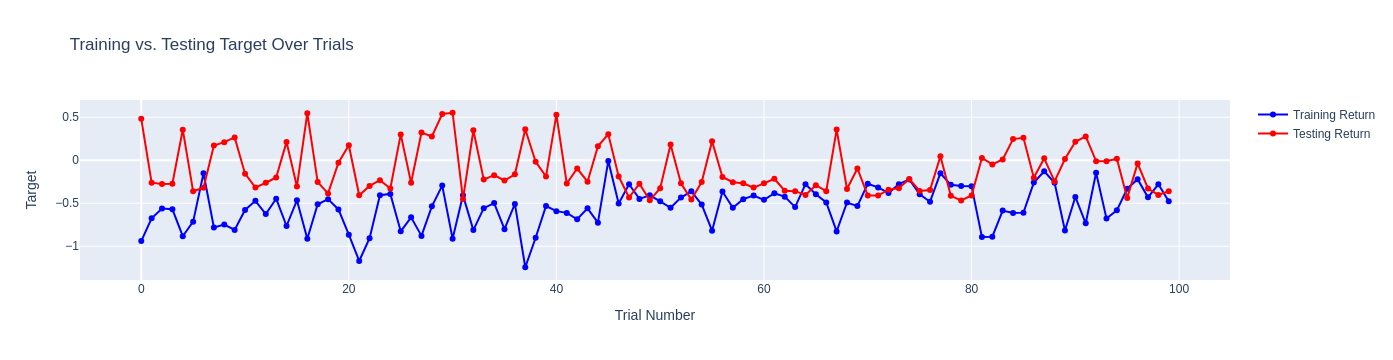

In [33]:
import plotly.graph_objects as go

# Assuming trial_performance['training'] and trial_performance['testing']
# are your data dictionaries for training and testing performance respectively
training_df = pd.DataFrame(trial_performance['training'])
testing_df = pd.DataFrame(trial_performance['testing'])

# Reset index to ensure alignment for comparison, if necessary
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

# Create traces for training and testing returns
trace1 = go.Scatter(
    x=training_df.index,
    y=training_df['target'],
    mode='lines+markers',
    name='Training Return',
    marker=dict(color='blue')
)

trace2 = go.Scatter(
    x=testing_df.index,
    y=testing_df['target'],
    mode='lines+markers',
    name='Testing Return',
    marker=dict(color='red')
)

# Define the layout
layout = go.Layout(
    title='Training vs. Testing Target Over Trials',
    xaxis=dict(title='Trial Number'),
    yaxis=dict(title='Target'),
    hovermode='closest'
)

# Create the figure and add traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the figure
fig.show()


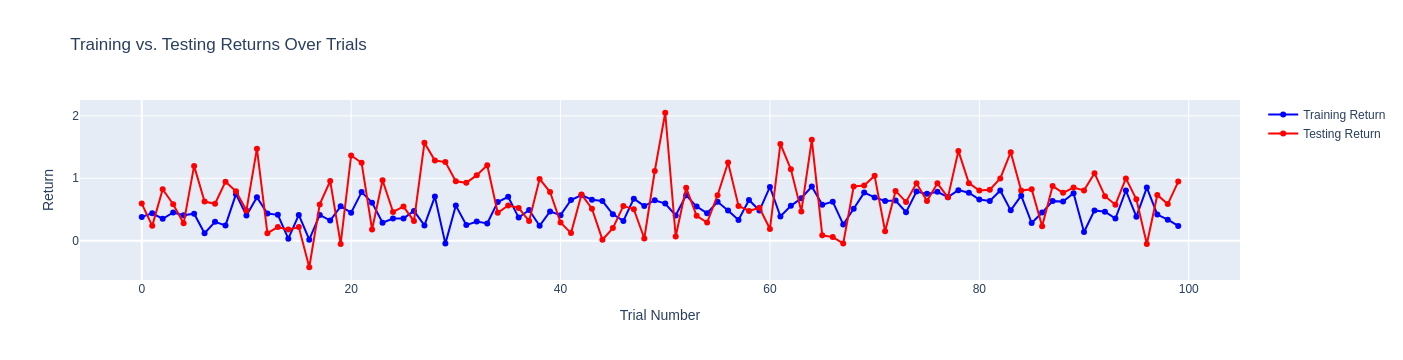

In [25]:
import plotly.graph_objects as go

# Assuming trial_performance['training'] and trial_performance['testing']
# are your data dictionaries for training and testing performance respectively
training_df = pd.DataFrame(trial_performance['training'])
testing_df = pd.DataFrame(trial_performance['testing'])

# Reset index to ensure alignment for comparison, if necessary
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

# Create traces for training and testing returns
trace1 = go.Scatter(
    x=training_df.index,
    y=training_df['return'], 
    mode='lines+markers',
    name='Training Return',
    marker=dict(color='blue')
)

trace2 = go.Scatter(
    x=testing_df.index,
    y=testing_df['return'], 
    mode='lines+markers',
    name='Testing Return',
    marker=dict(color='red')
)

# Define the layout
layout = go.Layout(
    title='Training vs. Testing Returns Over Trials',
    xaxis=dict(title='Trial Number'),
    yaxis=dict(title='Return'),
    hovermode='closest'
)

# Create the figure and add traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the figure
fig.show()

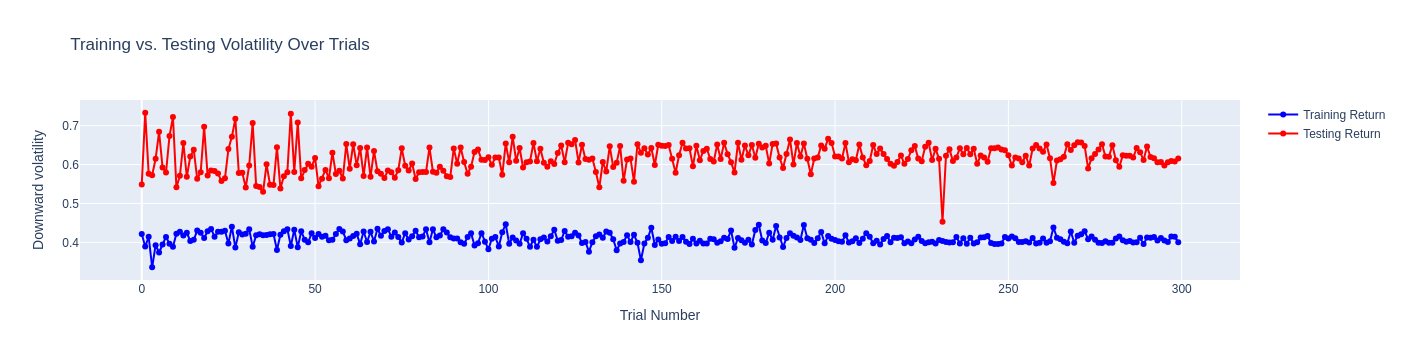

In [16]:
import plotly.graph_objects as go

# Assuming trial_performance['training'] and trial_performance['testing']
# are your data dictionaries for training and testing performance respectively
training_df = pd.DataFrame(trial_performance['training'])
testing_df = pd.DataFrame(trial_performance['testing'])

# Reset index to ensure alignment for comparison, if necessary
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

# Create traces for training and testing returns
trace1 = go.Scatter(
    x=training_df.index,
    y=training_df['volatility_d'], # volatility d
    mode='lines+markers',
    name='Training Return',
    marker=dict(color='blue')
)

trace2 = go.Scatter(
    x=testing_df.index,
    y=testing_df['volatility_d'],  # volatility d
    mode='lines+markers',
    name='Testing Return',
    marker=dict(color='red')
)

# Define the layout
layout = go.Layout(
    title='Training vs. Testing Volatility Over Trials',
    xaxis=dict(title='Trial Number'),
    yaxis=dict(title='Downward volatility'),
    hovermode='closest'
)

# Create the figure and add traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the figure
fig.show()

In [17]:
desired_params = {'u1': 0.2351388802138794, 'u2': 0.498096947360805, 'v1': 0.11799936923571375, 'v2': 0.04724297000744637} # Replace your normal
u = np.array([desired_params['u1'], desired_params['u2']])
u = u / np.sqrt(u @ u)
v = np.array([desired_params['v1'], desired_params['v2']])
v = v / np.sqrt(v @ v)
testing_handler.spot_statistics(u, v)

{'return': 1.1301234383834058,
 'volatility': 0.45193484385248445,
 'volatility_d': 0.6196431906966979,
 'mdd': 0.13311636802621774}

In [18]:
strategy = testing_handler.spot_strategy(u, v)
portfolio = testing_handler.spot_run(strategy)
activities = pd.merge(strategy, portfolio, on='open_time', how='inner')
activities['date'] = pd.to_datetime(activities['open_time'], unit='ms')
activities.set_index('date', inplace=True)
activities

,open_time,open,high,low,close,close_time,macd,macdsignal,buy,sell,buy_signal,sell_signal,strategy,token,usdt,value
date,,,,,,,,,,,,,,,,
2024-02-11 06:00:00,1707631200000,48224.71,48314.54,48125.00,48221.94,1707634799999,300.354421,253.487547,357.449272,373.054062,True,True,Hold,0.020736,1000.0,1999.942561
2024-02-11 07:00:00,1707634800000,48221.94,48355.00,48061.10,48179.52,1707638399999,296.522285,262.094495,363.596609,372.695526,True,True,Hold,0.020736,1000.0,1999.062929
2024-02-11 08:00:00,1707638400000,48179.51,48286.55,48075.87,48140.00,1707641999999,286.988135,267.073223,364.028773,365.694921,True,True,Hold,0.020736,1000.0,1998.243432
2024-02-11 09:00:00,1707642000000,48139.99,48223.59,48096.00,48139.99,1707645599999,276.247042,268.907987,361.102609,356.405278,True,True,Hold,0.020736,1000.0,1998.243224
2024-02-11 10:00:00,1707645600000,48140.00,48187.62,47922.33,48142.78,1707649199999,264.906105,268.107611,355.537415,345.579326,True,True,Hold,0.020736,1000.0,1998.301078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30 19:00:00,1714503600000,60403.68,60503.87,59191.60,59292.95,1714507199999,-818.787568,-564.102420,-859.655971,-969.796858,False,False,Hold,0.041098,0.0,2436.842154
2024-04-30 20:00:00,1714507200000,59292.95,60177.46,59274.75,59958.62,1714510799999,-835.674312,-618.416799,-915.981376,-1005.661599,False,False,Hold,0.041098,0.0,2464.200089
2024-04-30 21:00:00,1714510800000,59958.62,60400.00,59952.49,60180.00,1714514399999,-821.721369,-659.077713,-946.794578,-1007.821257,False,False,Hold,0.041098,0.0,2473.298441


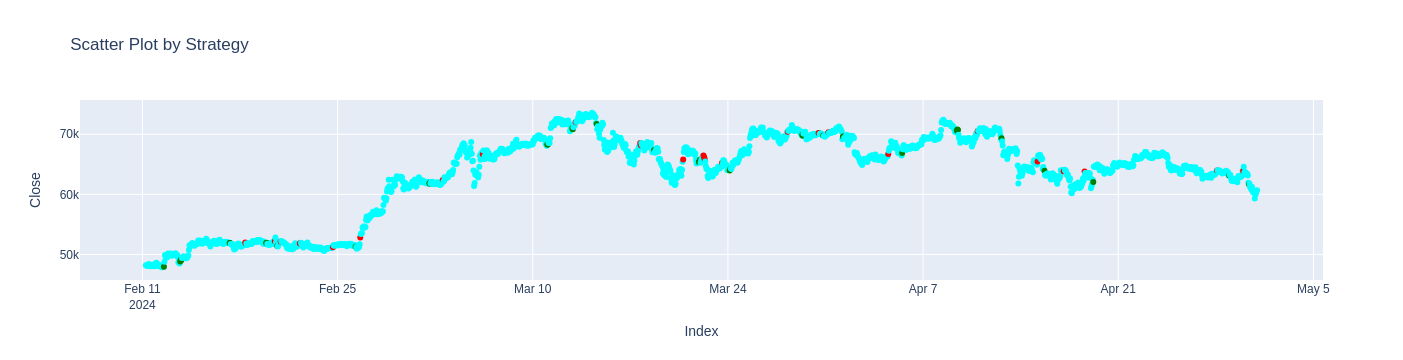

In [19]:
import pandas as pd
import plotly.graph_objects as go

# Define colors based on strategy
colors = activities['strategy'].map({'Buy': 'green', 'Sell': 'red'}).fillna('cyan')

# Create scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=activities.index,
    y=activities['close'],
    mode='markers',  # Use markers to create a scatter plot
    marker=dict(color=colors),  # Assign colors based on strategy
    # text=df['Strategy'],  # Optionally, display the strategy as hover text
))

# Update layout if needed
fig.update_layout(
    title="Scatter Plot by Strategy",
    xaxis_title="Index",
    yaxis_title="Close",
    legend_title="Strategy",
)

# Show plot
fig.show()


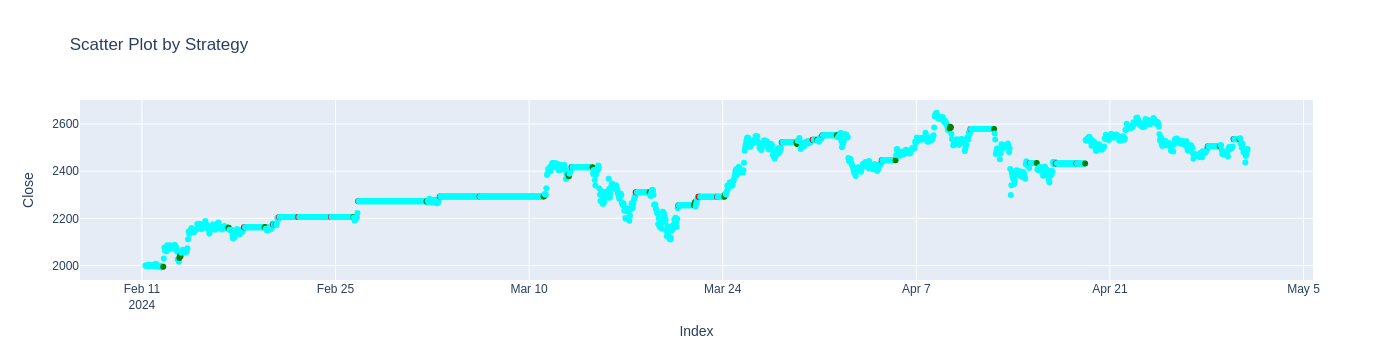

In [20]:
import pandas as pd
import plotly.graph_objects as go

# Define colors based on strategy
colors = activities['strategy'].map({'Buy': 'green', 'Sell': 'red'}).fillna('cyan')

# Create scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=activities.index,
    y=activities['value'],
    mode='markers',  # Use markers to create a scatter plot
    marker=dict(color=colors),  # Assign colors based on strategy
    # text=df['Strategy'],  # Optionally, display the strategy as hover text
))

# Update layout if needed
fig.update_layout(
    title="Scatter Plot by Strategy",
    xaxis_title="Index",
    yaxis_title="Close",
    legend_title="Strategy",
)

# Show plot
fig.show()